# Lesson 3 - Creating a structural n bit Full Adder #

The idea here is to create a slightly more complex structural circuit.
We will start by reusing the 1-bit full adder implemented in lesson 2

In [1]:
import sys
import platform
if (platform.uname().node == 'TPY14'):
    print('Dev machine')
    sys.path.append('..\\..\\..\\py4hw')

Dev machine


In [2]:
import py4hw

In [3]:
class FullAdder(py4hw.Logic):
    
    def __init__(self, parent, name, x, y, ci, s, co):
        super().__init__(parent, name)
        
        self.x = self.addIn('x', x)
        self.y = self.addIn('y', y)
        self.ci = self.addIn('ci', ci)
        self.s = self.addOut('s', s)
        self.co = self.addOut('co', co)

    def propagate(self):
        self.s.put((self.x.get() ^ self.y.get()) ^ self.ci.get())
        self.co.put((self.x.get() & self.y.get()) | ( (self.x.get() ^ self.y.get())  & self.ci.get()))

### Creating a little more complex Structural Circuit ###
When someone wants to create a repetivie structure in Verilog it can mix behavioural code with some specific statements to generate structures. 
This mix of design styles in the same description can cause some confusion on the language novices.
In py4hw we try to be very clear on the design level you are using, to try to avoid confusion. 

Structural circuits have all their code in the constructor.

A feature that can blow the mind of the typical Hardware designer is that signal (wire) widths are never specified in circuits. By default we assume that every circuit has parametric wire widths.

If the designer wants to limit wire widths to an specific value, he/she can still do it by adding assertions or exceptions checking wire widths.

An other aspect that can anoy the typical Hardware designer is the limitations to directly address bits from a wire.
We need circuits to extract bits from wires and to concatenate bits into wires.
The reason for this is that it greatly simplifies the simulation infrastructure, but at the same time, it forces the designer to carefully thing about which elements are driving the wires, avoiding errors.

In [4]:
class FullAdderN(py4hw.Logic):
    
    def __init__(self, parent, name, x, y, ci, s, co):
        super().__init__(parent, name)
        
        self.addIn('x', x)
        self.addIn('y', y)
        self.addIn('ci', ci)
        
        self.addOut('s', s)
        self.addOut('co', co)
        
        assert(ci.getWidth() == 1)
        assert(co.getWidth() == 1)
        assert(x.getWidth() == y.getWidth())
        assert(x.getWidth() == s.getWidth())
        
        xb = self.wires('xb', x.getWidth(), 1)
        yb = self.wires('yb', y.getWidth(), 1)
        sb = self.wires('sb', s.getWidth(), 1)
        
        py4hw.BitsLSBF(self, 'xb', x, xb)
        py4hw.BitsLSBF(self, 'yb', y, yb)
        py4hw.ConcatenateLSBF(self, 'sb', sb, s)
        
        pci = ci # partial carry in
        
        for i in range(x.getWidth()):
            pco = self.wire('co{}'.format(i))
            FullAdder(self, 'FA{}'.format(i), xb[i], yb[i], pci, sb[i], pco)
            pci = pco
            
        py4hw.Buf(self, 'co', pco, co)

### Visualizaing the circuit ## 

With the visualization we can easily see that carrys are daisy-chained, as we would expect

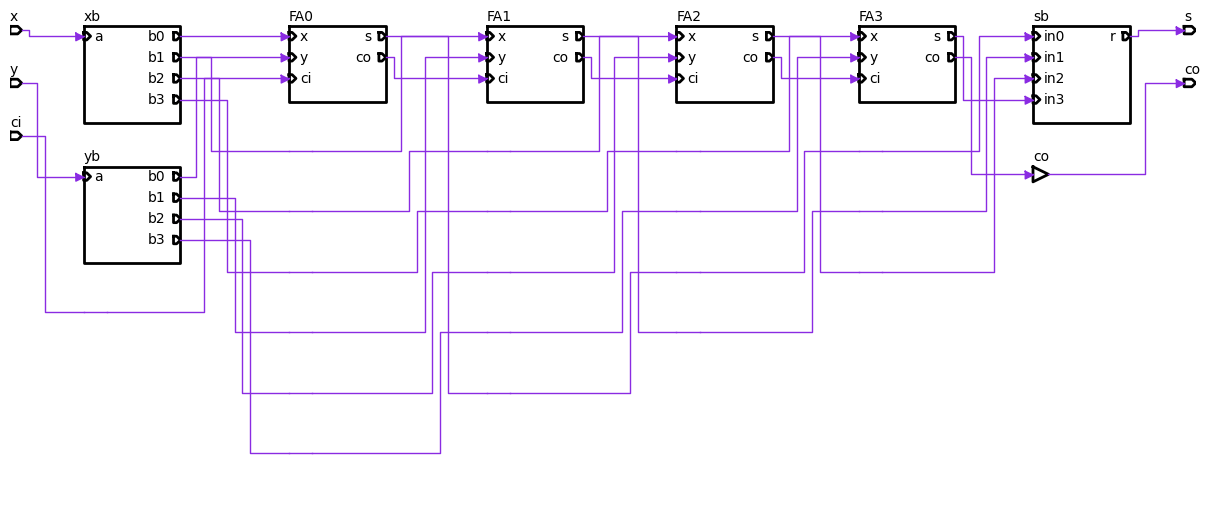

In [5]:
sys = py4hw.HWSystem()

x = sys.wire('x', 4)
y = sys.wire('y', 4)
ci = sys.wire('ci')
s = sys.wire('s', 4)
co = sys.wire('co')
fan = FullAdderN(sys, 'fa', x, y, ci, s, co)

sch = py4hw.Schematic(fan)
sch.draw()

### Simulating the System ###

To verify the correct behaviour of the system we can simulate it.

In [6]:
sys = py4hw.HWSystem()

x = sys.wire('x', 4)
y = sys.wire('y', 4)
ci = sys.wire('ci')
s = sys.wire('s', 4)
co = sys.wire('co')
fan = FullAdderN(sys, 'fa', x, y, ci, s, co)

py4hw.Sequence(sys, 'x', [1,3,5,7,9], x)
py4hw.Sequence(sys, 'y', [7,11], y)
py4hw.Sequence(sys, 'ci', [0, 0, 0, 0, 0, 1], ci)

wvf = py4hw.Waveform(sys, 'wvf', [x,y,ci,s,co])

sys.getSimulator().clk(20)
wvf.draw_wavedrom()

### Final Comments ###
This lesson was used to describe how to use [what other HDLs call] generative structural code.
If you come from a software background you will easily understand that instatiating an object from a class is equivalent to create a circuit, and if you put that instantiation inside a loop in will create a collection of objects.

On the other hand, in py4hw we try to promote the reuse of existing circuits. So we would encourage to use the Add circuit from the library to implement the same circuit.

In [7]:
sys = py4hw.HWSystem()

x = sys.wire('x', 4)
y = sys.wire('y', 4)
ci = sys.wire('ci')
s = sys.wire('s', 4)
co = sys.wire('co')
fan = py4hw.Add(sys, 'fa', x, y, s, ci, co)

py4hw.Sequence(sys, 'x', [1,3,5,7,9], x)
py4hw.Sequence(sys, 'y', [7,11], y)
py4hw.Sequence(sys, 'ci', [0, 0, 0, 0, 0, 1], ci)

wvf = py4hw.Waveform(sys, 'wvf', [x,y,ci,s,co])

sys.getSimulator().clk(20)
wvf.draw_wavedrom()